# Execises: A Tutorial on the Free-Energy Framework for Modelling Preception and Learning

In [2]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt

## Exercise 1:
 Assume that our animal observed the light intensity $u = 2$, the level of noise in its receptor is $\Sigma_u = 1$, and the mean and variance of its prior expectation of size are $v_p = 3$ and $\Sigma_p = 1$. Write a computer program that computes the posterior probabilities of sizes from $0.01$ to $5$, and plots them.

 N.B. : Likelihood $p(u \vert v) = f(u; g(v), \Sigma_u)$ and prior $p(v) = f(v; v_p, \Sigma_p)$

In [3]:
v_p = 3 # prior mean
sigma_p = 1 # prior variance

u = 2
sigma_u = 1

dt = 0.01
min_v = 0.01
max_v = 5

vrange = np.arange(min_v, max_v, dt)

In [4]:
def g(v):
    return v**2

def gdash(v):
    return 2*v

norm_p = norm.pdf(vrange, v_p, sigma_p)
norm_l = norm.pdf(u, g(vrange), sigma_u)

numerator = norm_l * norm_p
denominator = np.sum(numerator) * dt # integral of numerator

p_vu = numerator / denominator

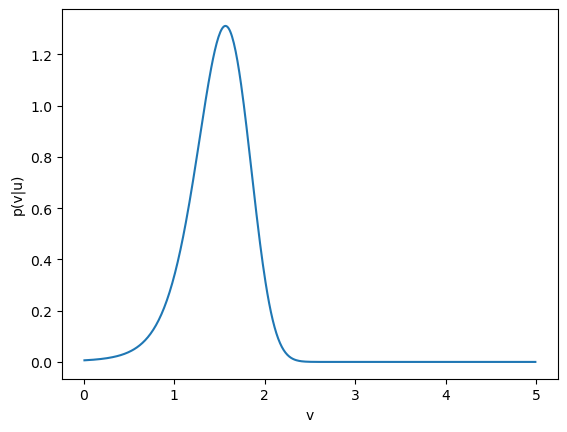

In [5]:
plt.plot(vrange, p_vu)
plt.xlabel('v')
plt.ylabel('p(v|u)')
plt.show()

## Exercise 2
Write a computer program finding the most likely size of the food item $\phi$ for the situation described in Exercise 1. Initialize $\phi = v_p$, and then find its values in the next $5$ time units (you can use Euler’s method, i.e. update $\phi(t + \Delta t) = \phi(t) + \Delta t \partial F/ \partial \phi$ with $\Delta t = 0.01$).

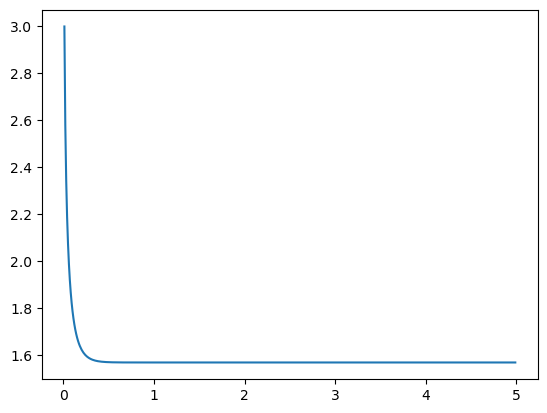

In [6]:
# v_p, sigma_p, u, sigma_u are the same as above
# vrange is the same as above

phi = np.zeros((len(vrange)))
phi[0] = v_p # initial value of phi

for i in range(1, len(vrange)):
    phi[i] = phi[i-1] + dt * ((v_p - phi[i-1]) / sigma_p**2 + (u - g(phi[i-1])) / sigma_u**2 * gdash(phi[i-1]))

plt.plot(vrange, phi)


## Exercise 3
Simulate model from Fig 3 (see below) for the problem in Exercise 1. In particular, initialise $\phi = v_p$, $\varepsilon_p = \varepsilon_u = 0$ and find their values for the next $5$ units of time.

<img src="Fig3.png" alt="Drawing" style="width: 400px;"/>

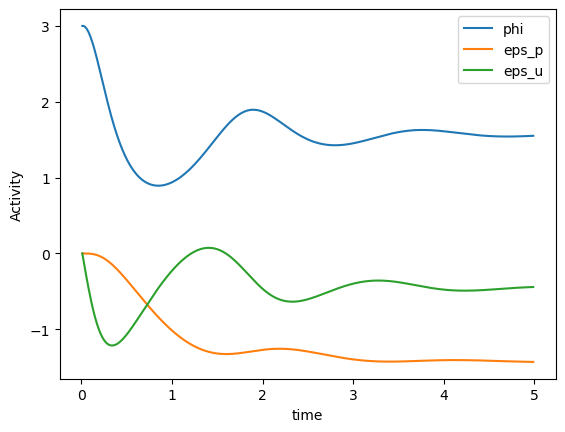

In [7]:
# Parameters above are identical to exercise 1
phi_3 = np.zeros((len(vrange)))
eps_p = np.zeros((len(vrange)))
eps_u = np.zeros((len(vrange)))

phi_3[0] = v_p
# The other two initial values are already covered upon initialisation
for i in range(1, len(vrange)):
    # Remember to use the NEW forms of the equations with the epsilons
    phi_3[i] = phi_3[i-1] + dt * (eps_u[i-1] * gdash(phi_3[i-1]) - eps_p[i-1])
    eps_p[i] = eps_p[i-1] + dt * (phi_3[i-1] - v_p - sigma_p * eps_p[i-1])
    eps_u[i] = eps_u[i-1] + dt * (u - g(phi_3[i-1]) - sigma_u * eps_u[i-1])

plt.plot(vrange, phi_3, label="phi")
plt.plot(vrange, eps_p, label="eps_p")
plt.plot(vrange, eps_u, label="eps_u")
plt.xlabel("time")
plt.ylabel("Activity")
plt.legend()
plt.show()


### Explanation of solution 3:
Q: Do they solve w.r.t. $\phi$ or $\varepsilon_u$ and $\varepsilon_p$?

A: Yes, they solve all three sets of equations at the same time. The Euler scheme now looks like this:

$\varepsilon_p(t+\Delta t) = \varepsilon_p(t) + \Delta t \, \dot{\varepsilon}_p$, and analagously for $\varepsilon_u$

and $\dot{\phi} = \varepsilon_u g'(\phi) - \varepsilon_p$ 

## Exercise 5
Simulate learning of variance $\Sigma_i$ over trials. For simplicity, only simulate the network described by Eqs. $(59)–(60)$, and assume that variables $\phi$ are constant. On each trial, generate input $\phi_i$ from a normal distribution with mean $5$ and variance $2$, while setting $g_i(\phi_{i+1}) = 5$ (so that the upper level correctly predicts the mean of $\phi_i$). Simulate the network for $20$ time units, and then update weight $\Sigma_i$ with learning rate $\alpha = 0.01$. Simulate $1000$ trials and plot how $\Sigma_i$ changes across trials.

We need to implement the following equations:

$\dot{\varepsilon}_i = \phi_i - g_i(\phi_{i+1}) - e_i$, noting that we randomly sample $\phi_i$ and that $g_i(\phi_{i+1}) = 5$

$\dot{e}_i = \Sigma_i \varepsilon_i - e_i$ **and**

$\Delta \Sigma_i = \alpha (\varepsilon_i e_i - 1)$

In [9]:
mean_phi = 5
sigma_phi = 2
phi_above = 5 # Describes $g_i(\phi_{i+1}) = 5$

# Parameters above are identical to exercise 1
max_t = 20 # max time unit
trials = 1000 # number of trials
alpha = 0.01 # learning rate

sigma = np.zeros(trials)
sigma[0] = 1

its = int(max_t / dt) # = 2000
error = np.zeros(its) # prediction error vector
e = np.zeros(its) # interneuron vector

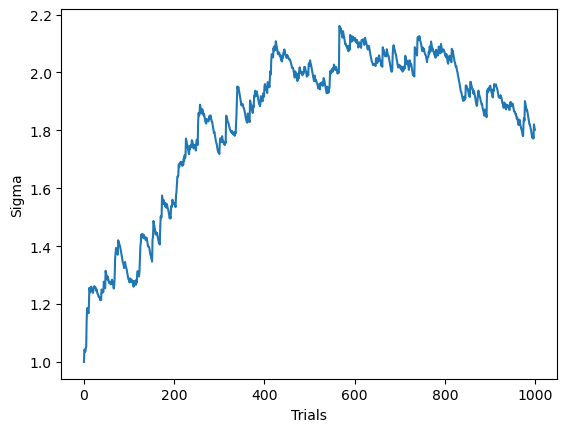

In [28]:
np.random.seed(seed=1) # for reproducibility
for i in range(1, trials): # Iterating over trials
    error[0] = 0
    e[0] = 0
    phi = norm.rvs(mean_phi, sigma_phi**.5) # samples from N(mean_phi, sigma_phi)
    
    for j in range(1, its): # Iterating because of Euler method
        error[j] = error[j-1] + dt * (phi - phi_above - e[j-1])
        e[j] = e[j-1] + dt * (sigma[i-1] * error[j-1] - e[j-1]) # i is the trial number!
    # Update sigma
    sigma[i] = sigma[i-1] + alpha * (error[-1] * e[-1] - 1)


plt.xlabel("Trials")
plt.ylabel("Sigma")
plt.plot(sigma)
plt.show()
    
    